In [1]:
import os
import shutil
import warnings

import numpy as np
import pandas as pd
import torchaudio

warnings.filterwarnings(action="ignore")
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import json

import geopandas
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.stats as st
import soundfile
import tensorflow as tf
import torch

%matplotlib inline
from PIL import Image
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

In [2]:
from src.prepare_dataset import prepare_dataset

In [3]:
with open("/app/_data/dict_birds.json", "r") as birds:
    dict_birds = json.load(birds)

In [4]:
rand_cut = pd.read_csv("/app/_data/random_cut1.csv")
# all_audio_init = pd.read_csv("/app/_data/all_audio_initial.csv")
SEED = 42
train_sound=pd.read_csv("/app/_data/train_soundscapes_prepared.csv")

In [6]:
# rand_cut.to_csv("/app/_data/random_cut1.csv", index=False)

In [7]:
# all_audio["norm_latitude"] = (all_audio["latitude"] + 90) / 180


In [8]:
train_sound  = prepare_dataset(train_sound)
rand_cut = prepare_dataset(rand_cut)

In [9]:
all_audio = pd.concat([rand_cut, train_sound], axis=0, ignore_index=True)


In [10]:
# all_audio = all_audio[all_audio["rating"] >= 4]
all_audio_sample = all_audio.sample(
    n=200000, weights="class_weights", random_state=SEED
)
all_audio_sample = all_audio_sample.reset_index(drop=True)
all_audio_500 = pd.read_csv("/app/_data/my/all_audio_500.csv")

In [11]:
class Mel_Provider:
    def __init__(
        self,
        n_fft,
        win_length,
        n_mels,
        sample_rate,
        mel_image_size,
        min_frequency,
        max_frequency,
        signal_lenght,
        hop_length=None,
        norm_mel=True,
        device="cpu",
    ):
        self.norm_mel = norm_mel
        self._device = device
        self.signal_lenght = signal_lenght
        self.sample_rate = sample_rate
        self.mel_image_size = mel_image_size
        if hop_length is None:
            self.hop_length = int(
                self.signal_lenght * self.sample_rate / self.mel_image_size - 1
            )
        else:
            self.hop_length = hop_length
        self._melspectrogram = torchaudio.transforms.MelSpectrogram(
            power=2.0,
            center=True,
            norm="slaney",
            onesided=True,
            win_length=win_length,
            pad_mode="reflect",
            n_fft=n_fft,
            n_mels=n_mels,
            sample_rate=sample_rate,
            hop_length=self.hop_length,
            f_min=min_frequency,
            f_max=max_frequency,
        ).to(self._device)

    def msg(self, wave):
        wave = torch.tensor(wave.reshape([1, -1]).astype(np.float32)).to(self._device)
        mel_spec = self._melspectrogram(wave)[0].cpu().numpy()
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        if self.norm_mel:
            mel_spec = (mel_spec - np.min(mel_spec)) / (
                np.max(mel_spec) - np.min(mel_spec)
            )
        mel_spec.astype(np.float32)
        return mel_spec

In [12]:
class MEL_Generator(keras.utils.Sequence):
    def __init__(
        self,
        df,
        n_mels,
        sample_rate,
        mel_image_size,
        signal_lenght,
        n_classes,
        seed,
        mel_provider=Mel_Provider,  # if not set, waves will be returned
        return_primary_labels=False,
        return_secondary_labels=False,
        return_concat_labels=True,
        convert_to_rgb=True,
        norm_mel=True,
        wave_dir=None,
        long_mel_dir=None,
        short_mel_dir=None,
        batch_size=32,
        shuffle=True,
        augmentation=None,
        sample_weight=True,
        device="cpu",
    ):
        self.mel_provider = mel_provider
        self.df = df.reset_index(drop=True)
        self.n_mels = n_mels
        self.sample_rate = sample_rate
        self.mel_image_size = mel_image_size
        self.signal_lenght = signal_lenght
        self.wave_dir = wave_dir
        self.long_mel_dir = long_mel_dir
        self.short_mel_dir = short_mel_dir
        self.norm_mel = norm_mel
        self.convert_to_rgb = convert_to_rgb
        self.sample_weight = sample_weight
        self.batch_size = batch_size
        self._shuffle = shuffle
        self.return_primary_labels = return_primary_labels
        self.return_secondary_labels = return_secondary_labels
        self.return_concat_labels = return_concat_labels
        self.n_classes = n_classes
        self._device = device
        self.seed = seed

        if self._shuffle:
            self._shuffle_samples()

    def __len__(self):
        return self.df.shape[0] // self.batch_size

    def long_msg(
        self,
        wave,
        file_name,
        save_mel=True,
    ):
        long_mel_dir = self.long_mel_dir
        if long_mel_dir is not None:
            if os.path.isfile(long_mel_dir + file_name + ".npy"):
                mel_spec = np.load(long_mel_dir + file_name + ".npy")
            else:
                mel_spec = self.mel_provider.msg(wave)
        else:
            mel_spec = self.mel_provider.msg(wave)
        if long_mel_dir is not None and save_mel:
            if not os.path.isfile(long_mel_dir + file_name + ".npy"):
                if not os.path.exists(long_mel_dir):
                    os.mkdir(long_mel_dir)
                np.save(long_mel_dir + file_name, mel_spec)
        return mel_spec

    def get_audio(
        self,
        file_path,
    ):
        wave_dir = self.wave_dir
        file_name = file_path.split("/")[-1][:-4]

        if wave_dir is not None:
            if os.path.isfile(wave_dir + file_name + ".npy"):
                wave = np.load(wave_dir + file_name + ".npy")
            else:
                wave, sr = librosa.load(file_path, sr=self.sample_rate)
        else:
            wave, sr = librosa.load(file_path, sr=self.sample_rate)
        if wave_dir is not None:
            if not os.path.isfile(wave_dir + file_name + ".npy"):
                if not os.path.exists(wave_dir):
                    os.mkdir(wave_dir)
                np.save(wave_dir + file_name, wave)
        return wave, file_name

    def on_epoch_start(self):
        if self._shuffle:
            self._shuffle_samples()

    def __getitem__(self, batch_ix):
        b_X = np.zeros(
            (self.batch_size, self.mel_image_size, self.mel_image_size, 3),
            dtype=np.uint8,
        )

        b_Y = np.zeros(
            (self.batch_size, self.n_classes),
            dtype=np.uint8,
        )

        for i in range(self.batch_size):
            b_X[i] = self._get_one(
                i + self.batch_size * batch_ix,
            )["image"]
            b_Y[i] = self._get_one(
                i + self.batch_size * batch_ix,
            )["labels"]

        return (b_X, b_Y)

    def _get_one(self, ix):

        file_path = self.df.loc[ix, "file_path"]
        rating = self.df.loc[ix, "rating"]
        label_id = self.df.loc[ix, "label_id"]
        year = self.df.loc[ix, "year"]
        start_sec = self.df.loc[ix, "start_sec"]
        end_sec = self.df.loc[ix, "end_sec"]
        file_name = self.df.loc[ix, "filename"][:-4]
        new_filename = self.df.loc[ix, "row_id"]

        if os.path.isfile(self.short_mel_dir + new_filename + ".npy"):
            mel_spec = np.load(self.short_mel_dir + new_filename + ".npy")
            long_mel_spec = np.load(self.long_mel_dir + file_name + ".npy")
        else:
            if os.path.isfile(self.long_mel_dir + file_name + ".npy"):
                long_mel_spec = np.load(self.long_mel_dir + file_name + ".npy")

            else:
                wave, filename = self.get_audio(
                    file_path,
                )
                long_mel_spec = self.long_msg(wave, filename, save_mel=True)

            start = int((start_sec * self.mel_image_size) / self.signal_lenght)
            mel_spec = long_mel_spec[:, start : start + self.mel_image_size]

            if mel_spec.shape != (self.mel_image_size, self.mel_image_size):
                mel_spec = Image.fromarray(mel_spec)
                mel_spec = mel_spec.resize(
                    (self.mel_image_size, self.mel_image_size),
                    Image.BICUBIC,
                )
            # return as rgb uint8 image
            if self.convert_to_rgb:
                mel_spec = np.round(mel_spec * 255)
                mel_spec = np.repeat(np.expand_dims(mel_spec.astype(np.uint8), 2), 3, 2)
                mel_spec[self.mel_image_size - 15 :, :20, 0] = (
                    255 * self.df.loc[ix, "sin_month"]
                )
                mel_spec[self.mel_image_size - 15 :, :20, 1] = 255
                mel_spec[self.mel_image_size - 15 :, :20, 2] = 0
                mel_spec[self.mel_image_size - 15 :, 20:40, 0] = 255
                mel_spec[self.mel_image_size - 15 :, 20:40, 1] = (
                    255 * self.df.loc[ix, "cos_month"]
                )
                mel_spec[self.mel_image_size - 15 :, 20:40, 2] = 0
                mel_spec[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 60 : self.mel_image_size - 40,
                    0,
                ] = (
                    255 * self.df.loc[ix, "sin_longitude"]
                )
                mel_spec[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 60 : self.mel_image_size - 40,
                    1,
                ] = 255
                mel_spec[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 60 : self.mel_image_size - 40,
                    2,
                ] = 255
                mel_spec[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 40 : self.mel_image_size - 20,
                    0,
                ] = 255
                mel_spec[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 40 : self.mel_image_size - 20,
                    1,
                ] = (
                    255 * self.df.loc[ix, "cos_longitude"]
                )
                mel_spec[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 40 : self.mel_image_size - 20,
                    2,
                ] = 255
                mel_spec[
                    self.mel_image_size - 15 :, self.mel_image_size - 20 :, 0
                ] = 255
                mel_spec[
                    self.mel_image_size - 15 :, self.mel_image_size - 20 :, 1
                ] = 255
                mel_spec[self.mel_image_size - 15 :, self.mel_image_size - 20 :, 2] = (
                    255 * self.df.loc[ix, "norm_latitude"]
                )

                if not os.path.exists(self.short_mel_dir):
                    os.mkdir(self.short_mel_dir)
                np.save(self.short_mel_dir + new_filename, mel_spec)

        primary_y = np.zeros(self.n_classes)
        secondary_y = np.zeros(self.n_classes)

        assert (
            self.return_primary_labels
            + self.return_concat_labels
            + self.return_secondary_labels
            == 1
        ), "only one of return_primary_labels, return_concat_labels or return_secondary_labels can be True"
        if self.return_primary_labels or self.return_concat_labels:
            primary_y[self.df.loc[ix, "label_id"]] = 1
            if self.return_primary_labels:
                y = primary_y
        if self.return_secondary_labels or self.return_concat_labels:
            if type(self.df.loc[ix, "secondary_labels_id"])==float:
                secondary_y = secondary_y
            else:
                for i in self.df.loc[ix, "secondary_labels_id"].split(" "):
                    i = int(i)
                    secondary_y[i] = 0.3
            if self.return_secondary_labels:
                y = secondary_y

        if self.return_concat_labels:
            y = primary_y + secondary_y
            y = np.where(y > 1, 1, y)

        # sample weight
        if self.sample_weight:
            sw = self.df.loc[ix, "class_weights"]  # type: ignore

        assert mel_spec.shape == (self.n_mels, self.mel_image_size, 3) or (
            self.n_mels,
            self.mel_image_size,
        )
        return {
            "image": mel_spec,
            "labels": y,
            "sample_weight": sw,
            "filename": file_name,
            "file_path": file_path,
            "short_file_path": self.short_mel_dir + new_filename + ".npy",
            "long_mel_spec": long_mel_spec,
        }

    def _shuffle_samples(self):
        self.df = self.df.sample(frac=1, random_state=self.seed).reset_index(drop=True)

In [13]:
SEED = 42
IMG_SIZE = 260
SAMPLE_RATE = 32000
N_FFT = 2048
SIGNAL_LENGTH = 5  # seconds
FREQ_MIN = 500
FREQ_MAX = 15000
MAX_AUDIO_FILES = 100
WIN_LENGHT = 1024
AUDIO_PATH = "/app/_data/train_short_audio/"
BATCH_SIZE = 128

In [14]:
data = all_audio_sample.sample(n=10000, weights="class_weights", random_state=SEED)

In [15]:
shutil.rmtree("/app/_data/npy/long_mels_test/")
shutil.rmtree("/app/_data/npy/short_mels_test/")
shutil.rmtree("/app/_data/npy/waves_npy_test/")

In [16]:
ms = Mel_Provider(
    n_fft=N_FFT,
    win_length=WIN_LENGHT,
    n_mels=IMG_SIZE,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    min_frequency=FREQ_MIN,
    max_frequency=FREQ_MAX,
    signal_lenght=SIGNAL_LENGTH,
)

In [17]:
gen = MEL_Generator(
    df=data,
    n_mels=IMG_SIZE,
    seed=SEED,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    n_classes=398,
    signal_lenght=SIGNAL_LENGTH,
    mel_provider=ms,
    wave_dir="/app/_data/npy/waves_npy_test/",
    long_mel_dir="/app/_data/npy/long_mels_test/",
    short_mel_dir="/app/_data/npy/short_mels_test/",
    norm_mel=True,
    convert_to_rgb=True,
    shuffle=False,
    return_primary_labels=False,
    return_secondary_labels=False,
    return_concat_labels=True,
)

In [18]:
b = gen._get_one(22)
b["filename"]
b["file_path"]
b['short_file_path']
b["long_mel_spec"].shape
b["long_mel_spec"].shape[1] // 260

'XC259111'

'/app/_data/train_short_audio/whbman1/XC259111.ogg'

'/app/_data/npy/short_mels_test/XC259111_9_91.npy'

(260, 975)

3

In [19]:
b['labels']

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0.3, 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.

In [ ]:
# import IPython.display as ipd
# x.shape[0] // 32000
# x, sr = librosa.load(b["file_path"], sr=32000)
# ipd.Audio(x, rate=32000)

In [126]:
# dict_nocall = {"/app/_data/train_short_audio/thbkin/XC282319.ogg": [0, 520]}

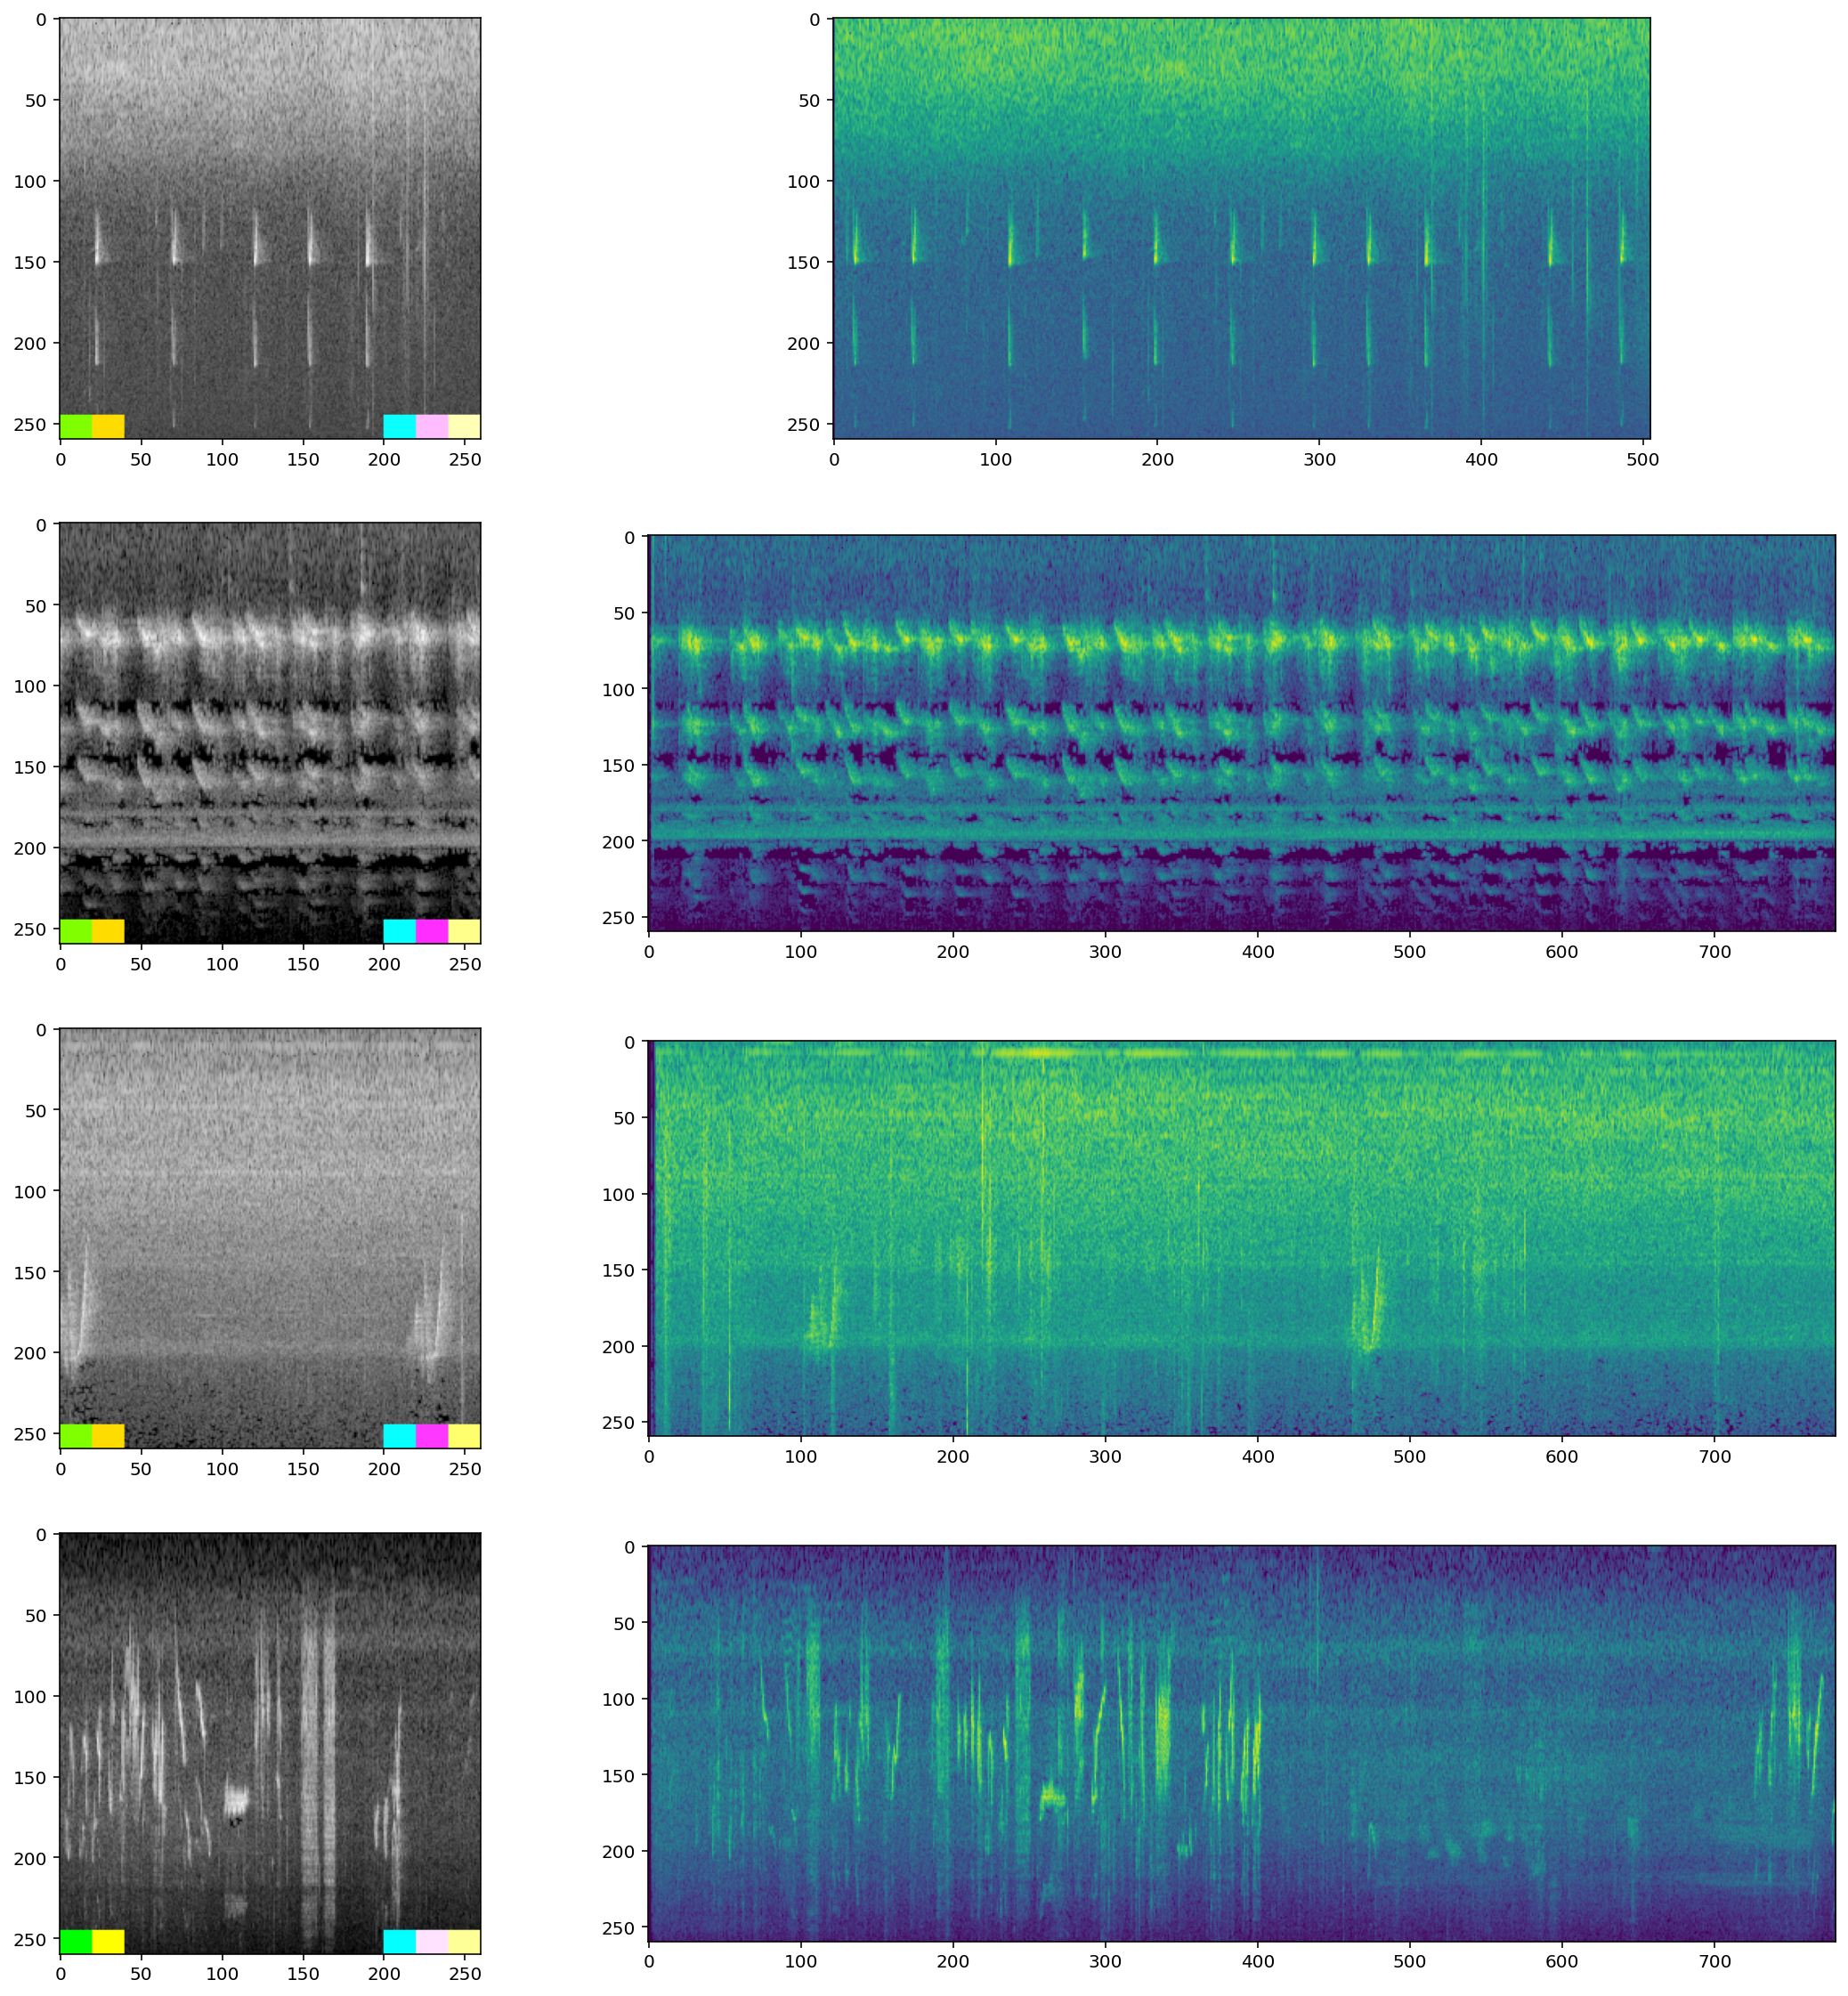

In [125]:
# fig = plt.figure(figsize=(25, 20))
# gs = fig.add_gridspec(4, 4)
# for i,j in enumerate(range(4,8)):
#     b = gen._get_one(j)
#     fig_1 = fig.add_subplot(gs[i, 1])
#     fig_1.imshow(b["image"])
#     fig_1 = fig.add_subplot(gs[i, 2:])
#     plt.imshow(b["long_mel_spec"][:, 0 : 260 * 3])
# plt.show();

In [127]:
a = next(iter(gen))

In [1]:
a[1][0]

NameError: name 'a' is not defined

# make imgs

In [124]:
all_audio = pd.read_csv("/app/_data/all_audio_initial.csv")

In [111]:
all_audio_500 = pd.read_csv("/app/_data/my/all_audio_500.csv")

In [51]:
all_audio_500 = all_audio_500.query('primary_label != "nocall"')

In [55]:
all_audio_500 = all_audio_500.query("duration>=20")

In [57]:
all_audio_500 = all_audio_500.sample(1000)

In [58]:
all_audio_500

barswa     21
sonspa     19
daejun     19
carwre     18
comrav     17
           ..
grhcha1     1
sposan      1
mouqua      1
compot1     1
lotman1     1
Name: primary_label, Length: 168, dtype: int64

In [139]:
all_audio[(all_audio["rating"] == 6.0) & (all_audio["primary_label"] != "nocall")][
    "filename"
].value_counts()

2782_SSW_20170701.ogg     120
28933_SSW_20170408.ogg    102
21767_COR_20190904.ogg     98
18003_COR_20190904.ogg     96
51010_SSW_20170513.ogg     92
44957_COR_20190923.ogg     71
26709_SSW_20170701.ogg     58
10534_SSW_20170429.ogg     57
26746_COR_20191004.ogg     49
42907_SSW_20170708.ogg     45
57610_COR_20190904.ogg     27
54955_SSW_20170617.ogg     20
11254_COR_20190904.ogg     15
14473_SSW_20170701.ogg      8
50878_COR_20191004.ogg      5
7843_SSW_20170325.ogg       4
20152_SSW_20170805.ogg      4
Name: filename, dtype: int64

In [145]:
all_audio[
    (all_audio["rating"] == 6) & (all_audio["filename"] == "2782_SSW_20170701.ogg")
][["primary_label", "row_id"]].sample(5)

primary_label        row_id
64180  bkcchi eawpew reevir1  2782_SSW_535
64117  eawpew grycat reevir1  2782_SSW_220
64102         eawpew reevir1  2782_SSW_145
64107         eawpew reevir1  2782_SSW_170
64086  bkcchi eawpew reevir1   2782_SSW_65

In [134]:
dd = pd.read_csv("/app/_data/train_soundscape_labels_orig.csv")

In [135]:
dd['audio_id']==

row_id site  audio_id  seconds   birds
0        7019_COR_5  COR      7019        5  nocall
1       7019_COR_10  COR      7019       10  nocall
2       7019_COR_15  COR      7019       15  nocall
3       7019_COR_20  COR      7019       20  nocall
4       7019_COR_25  COR      7019       25  nocall
...             ...  ...       ...      ...     ...
2395  54955_SSW_580  SSW     54955      580  nocall
2396  54955_SSW_585  SSW     54955      585  grycat
2397  54955_SSW_590  SSW     54955      590  grycat
2398  54955_SSW_595  SSW     54955      595  nocall
2399  54955_SSW_600  SSW     54955      600  nocall

[2400 rows x 5 columns]